### Read this notebook first

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import beta

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

Table references:
- imputed_details: games_details table with 0s filled in for players that didn't play so have no game stats
- games_wo_nan: games table with rows with NaNs deleted (99 rows deleted, <1% of data)
- teams_refined: teams table with only columns of interest

- merged_df: merged imputed_details, games_wo_nan
- merged_df_all: merged merged_df, teams_refined, and calculated PER per player per game

- player_overall_per: table with PER for each player, each season
- team_overall_chemistry: table team chemistry per team, per season

SECTION 0: Loading Data and Metadata

In [145]:
details = pd.read_csv("games_details.csv")
details.head()

/var/folders/sm/0dqpn8sx01v9pzyj0v4hn1sh0000gn/T/ipykernel_22545/1543314843.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv("games_details.csv")


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [146]:
games = pd.read_csv("games.csv")
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [147]:
ranking = pd.read_csv("ranking.csv")
ranking.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612743,0,22022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,NaN
1,1610612763,0,22022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,NaN
2,1610612740,0,22022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,NaN
3,1610612756,0,22022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,NaN
4,1610612746,0,22022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,NaN


In [148]:
teams = pd.read_csv("teams.csv")
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [149]:
metadata = [('Details:', details), ('Games:', games), ('Ranking:', ranking), ('Teams: ', teams)]

print('Game Metadata\n')
for k, v in metadata:
    print(k, v.shape) 

Game Metadata

Details: (668628, 29)
Games: (26651, 21)
Ranking: (210342, 13)
Teams:  (30, 14)


SECTION 1: Data Cleaning

Tables with only desired columns

In [150]:
details_refined = details[['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME', 
    'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']]
details_refined.head()

,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,AST,STL,BLK,TO,PF,PTS
0,22200477,1610612759,1629641,Romeo Langford,F,NaN,18:06,1.0,1.000,0.000,0.0,1.0,1.0,0.0,1.0,0.0,2.0,5.0,2.0
1,22200477,1610612759,1631110,Jeremy Sochan,F,NaN,31:01,7.0,0.500,0.500,0.7,6.0,3.0,6.0,1.0,0.0,2.0,1.0,23.0
2,22200477,1610612759,1627751,Jakob Poeltl,C,NaN,21:42,6.0,0.667,0.000,1.0,1.0,3.0,1.0,1.0,0.0,2.0,4.0,13.0
3,22200477,1610612759,1630170,Devin Vassell,G,NaN,30:20,4.0,0.308,0.167,1.0,0.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0
4,22200477,1610612759,1630200,Tre Jones,G,NaN,27:44,7.0,0.583,0.333,1.0,0.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0


In [151]:
games_refined = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'FG_PCT_home',
                       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'PTS_away', 'FG_PCT_away', 'FG3_PCT_away', 
                       'AST_away', 'REB_away', 'HOME_TEAM_WINS']]
games_refined.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,1610612740,1610612759,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.321,23.0,44.0,1
1,2022-12-22,22200478,1610612762,1610612764,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.333,20.0,37.0,1
2,2022-12-21,22200466,1610612739,1610612749,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.433,20.0,46.0,1
3,2022-12-21,22200467,1610612755,1610612765,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.261,15.0,46.0,1
4,2022-12-21,22200468,1610612737,1610612741,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.292,20.0,47.0,0


In [152]:
ranking_refined = ranking[['TEAM_ID', 'STANDINGSDATE', 'G', 'W', 'L', 'W_PCT', 'HOME_RECORD', 'ROAD_RECORD']]
ranking_refined

,TEAM_ID,STANDINGSDATE,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD
0,1610612743,2022-12-22,30,19,11,0.633,10-3,9-8
1,1610612763,2022-12-22,30,19,11,0.633,13-2,6-9
2,1610612740,2022-12-22,31,19,12,0.613,13-4,6-8
3,1610612756,2022-12-22,32,19,13,0.594,14-4,5-9
4,1610612746,2022-12-22,33,19,14,0.576,11-7,8-7
...,...,...,...,...,...,...,...,...
210337,1610612765,2014-09-01,82,29,53,0.354,17-24,12-29
210338,1610612738,2014-09-01,82,25,57,0.305,16-25,9-32
210339,1610612753,2014-09-01,82,23,59,0.280,19-22,4-37
210340,1610612755,2014-09-01,82,19,63,0.232,10-31,9-32


In [153]:
teams_refined = teams[['TEAM_ID', 'MIN_YEAR', 'NICKNAME', 'ARENACAPACITY']]
teams_refined.head()

,TEAM_ID,MIN_YEAR,NICKNAME,ARENACAPACITY
0,1610612737,1949,Hawks,18729.0
1,1610612738,1946,Celtics,18624.0
2,1610612740,2002,Pelicans,NaN
3,1610612741,1966,Bulls,21711.0
4,1610612742,1980,Mavericks,19200.0


In [154]:
teams_refined.loc[teams_refined["NICKNAME"] == "Pelicans", "ARENACAPACITY"] = 17791
teams_refined.loc[teams_refined["NICKNAME"] == "Suns", "ARENACAPACITY"] = 18422
teams_refined.loc[teams_refined["NICKNAME"] == "Magic", "ARENACAPACITY"] = 18500
teams_refined.loc[teams_refined["NICKNAME"] == "Nets", "ARENACAPACITY"] = 19000
teams_refined.loc[teams_refined["NICKNAME"] == "76ers", "ARENACAPACITY"] = 20318

Checking column types

In [157]:
type(games_refined['GAME_DATE_EST'][0])

str

In [158]:
def df_column_printer(df):
    for col in df:
        print(f"Column '{col}'[{df[col].dtype}]")

In [159]:
df_column_printer(details_refined)

Column 'GAME_ID'[int64]
Column 'TEAM_ID'[int64]
Column 'PLAYER_ID'[int64]
Column 'PLAYER_NAME'[object]
Column 'START_POSITION'[object]
Column 'COMMENT'[object]
Column 'MIN'[object]
Column 'FGM'[float64]
Column 'FG_PCT'[float64]
Column 'FG3_PCT'[float64]
Column 'FT_PCT'[float64]
Column 'OREB'[float64]
Column 'DREB'[float64]
Column 'AST'[float64]
Column 'STL'[float64]
Column 'BLK'[float64]
Column 'TO'[float64]
Column 'PF'[float64]
Column 'PTS'[float64]


In [160]:
df_column_printer(games_refined)

Column 'GAME_DATE_EST'[object]
Column 'GAME_ID'[int64]
Column 'HOME_TEAM_ID'[int64]
Column 'VISITOR_TEAM_ID'[int64]
Column 'SEASON'[int64]
Column 'PTS_home'[float64]
Column 'FG_PCT_home'[float64]
Column 'FT_PCT_home'[float64]
Column 'FG3_PCT_home'[float64]
Column 'AST_home'[float64]
Column 'REB_home'[float64]
Column 'PTS_away'[float64]
Column 'FG_PCT_away'[float64]
Column 'FG3_PCT_away'[float64]
Column 'AST_away'[float64]
Column 'REB_away'[float64]
Column 'HOME_TEAM_WINS'[int64]


In [161]:
df_column_printer(ranking_refined)

Column 'TEAM_ID'[int64]
Column 'STANDINGSDATE'[object]
Column 'G'[int64]
Column 'W'[int64]
Column 'L'[int64]
Column 'W_PCT'[float64]
Column 'HOME_RECORD'[object]
Column 'ROAD_RECORD'[object]


Checking NaN Values and Imputation

In [162]:
details_refined[details_refined['MIN'].isna()]

,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,AST,STL,BLK,TO,PF,PTS
13,22200477,1610612759,203476,Gorgui Dieng,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,22200478,1610612762,1630695,Micah Potter,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,22200466,1610612749,203648,Thanasis Antetokounmpo,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,22200466,1610612749,201588,George Hill,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,22200466,1610612749,201586,Serge Ibaka,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665946,21200003,1610612747,203135,Robert Sacre,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665958,21200001,1610612764,201858,Cartier Martin,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665969,21200001,1610612739,201956,Omri Casspi,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665970,21200001,1610612739,202720,Jon Leuer,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Discovered that it seems like those with NaN in one game stats column also has NaN in other game stats column, so hypothesized that this might be because the player didn't play in that game at all. If this is the case, that means we can impute 0 for all the game stats for that player. To check if this is the case, I checked the comments column and see if those with NaN for their game stats have comments that indicated they did not play.

In [163]:
def create_frequency_table(df, col):
    frequency = df[col].value_counts()
    frequency_table = pd.DataFrame(frequency).transpose()
    return frequency_table

In [164]:
unique_comments = create_frequency_table(details_refined, 'COMMENT')
unique_comments.head()

COMMENT,DNP - Coach's Decision,DNP - Coach's Decision,DND - Injury/Illness,DNP - Injury/Illness,DNP - Injury/Illness,DND - Injury/Illness,DND - Sprained Left Ankle,NWT - Injury/Illness,DND - Rest,DND - Sprained Right Ankle,...,DND - Left Knee Bone Contusion,DND- Sore Left Knee,DNP - Left Foot Sprain,DND - Right Quadriceps Strain,NWT - Ankle sprain,DND - Strained rt. calf,DND - Left Achilles Surgery.,DND - Tendonitis Left Ankle,DND - Right quadriceps strain,"DND - Non-Displaced Fracture, Left Fibul"
count,58054,30547,1267,1161,1151,912,257,252,240,185,...,1,1,1,1,1,1,1,1,1,1


In [165]:
unique_comments.iloc[0].sum()

109689

The number of NaNs for game stats basically perfectly matches up with the number of rows that have a comment (rather than NaN for comment), thereby confirming my hypothesis. I then wrote the function below to check if these comments are all related to the player not playing, such as dnd (did not dress), dnp (did not play), nwt (not with team), etc.

In [166]:
def check_columns_for_keywords(df, keywords=['DND', 'DNP', 'NWT', 'DNT', 'Did Not Dress', 'Not With Team', 'Did Not Travel']):
    columns_without_keywords = []

    for col in df.columns:
        if not any(keyword in str(df[col]) for keyword in keywords):
            columns_without_keywords.append(col)

    return columns_without_keywords

In [167]:
check_columns_for_keywords(unique_comments)

['NBA Suspension',
 'NBA SUSPENSION',
 'Not with team - NBA suspension',
 'Not with team',
 'OUT - Sore Right Groin',
 'Inactive - Injury/Illness               ',
 'OUT- Sore Right Ankle',
 'MWT - Strained right calf.',
 'Not with team - left heel',
 'Did not dress - Flu-like symptoms',
 'Not with team - Personal reasons',
 'Not with Team',
 'NOT WITH TEAM - LEFT HIP STRAIN',
 'NOT WITH TEAM - PERSONAL REASONS',
 'NOT WITH TEAM - FLU',
 'Will Not Play - Sore Left Hamstring',
 'INJ - Arthroscopic Surgery Left Knee',
 'Not with team - Illness',
 'Not with team - Torn ACL - left knee',
 'NOT WITH TEAM - UPPER RESPIRATORY INFECT',
 'NOT WITH TEAM - LEFT KNEE SURGERY',
 'Did not Dress - Left Wrist Sprain',
 'Not with team - left achilles']

In [168]:
#imputing nan with 0s now that we have determined these are players that didn't play
def impute_nan_with_zero(df, cols_to_impute):
    for col in cols_to_impute:
        df[col].fillna(0, inplace=True)

    return df

In [169]:
imputed_details = impute_nan_with_zero(details_refined, ['MIN', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS'])
imputed_details

/var/folders/sm/0dqpn8sx01v9pzyj0v4hn1sh0000gn/T/ipykernel_22545/401113098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(0, inplace=True)


,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,AST,STL,BLK,TO,PF,PTS
0,22200477,1610612759,1629641,Romeo Langford,F,NaN,18:06,1.0,1.000,0.000,0.000,1.0,1.0,0.0,1.0,0.0,2.0,5.0,2.0
1,22200477,1610612759,1631110,Jeremy Sochan,F,NaN,31:01,7.0,0.500,0.500,0.700,6.0,3.0,6.0,1.0,0.0,2.0,1.0,23.0
2,22200477,1610612759,1627751,Jakob Poeltl,C,NaN,21:42,6.0,0.667,0.000,1.000,1.0,3.0,1.0,1.0,0.0,2.0,4.0,13.0
3,22200477,1610612759,1630170,Devin Vassell,G,NaN,30:20,4.0,0.308,0.167,1.000,0.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0
4,22200477,1610612759,1630200,Tre Jones,G,NaN,27:44,7.0,0.583,0.333,1.000,0.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668623,11200005,1610612743,202706,Jordan Hamilton,NaN,NaN,19,4.0,0.444,0.500,0.857,0.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0
668624,11200005,1610612743,202702,Kenneth Faried,NaN,NaN,23,7.0,0.636,0.000,1.000,1.0,0.0,1.0,1.0,0.0,3.0,3.0,18.0
668625,11200005,1610612743,201585,Kosta Koufos,NaN,NaN,15,3.0,0.429,0.000,0.000,3.0,5.0,0.0,1.0,0.0,0.0,3.0,6.0
668626,11200005,1610612743,202389,Timofey Mozgov,NaN,NaN,19,1.0,1.000,0.000,0.000,1.0,2.0,1.0,0.0,0.0,4.0,2.0,2.0


In [170]:
nan_pts = games_refined[games_refined['PTS_home'].isna()]
nan_pts

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
19175,2003-10-24,10300116,1610612753,1610612762,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19176,2003-10-24,10300108,1610612737,1610612764,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19177,2003-10-24,10300109,1610612738,1610612751,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19178,2003-10-24,10300113,1610612759,1610612745,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19179,2003-10-24,10300112,1610612749,1610612765,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19269,2003-10-09,10300019,1610612743,1610612756,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19270,2003-10-09,10300022,1610612757,1610612758,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19271,2003-10-08,10300013,1610612759,1610612763,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19278,2003-10-08,10300015,1610612747,1610612744,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [173]:
check_nan_relationship(nan_pts, 'PTS_home', ['FG_PCT_home',
                       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'PTS_away', 'FG_PCT_away', 'FG3_PCT_away', 
                       'AST_away', 'REB_away', 'HOME_TEAM_WINS'])

['HOME_TEAM_WINS']

HOME_TEAM_WINS is the only column that doesn't have NaN value for when PTS_home is NaN. THe unique value of HOME_TEAM_WINS is also only 0. Unable to individually check if all of the home_team_wins are truly that the home team lost (although a quick Google search on random rows seemed to indicate so), these game stats won't be as valid/ accurate.

Seems like all the teams have na values, and all are during a specific timeframe in the 2003 season (namely between 2003-10-07 to 2003-10-24). It has also been shown that those with NaN in PTS_home column is also NaN in all the other columns on game stats. Since it's only 99 rows out of the entire games dataset, will drop these rows from the model.

In [174]:
games_wo_nan = games_refined.dropna(subset=['PTS_home'])
games_wo_nan

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,1610612740,1610612759,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.321,23.0,44.0,1
1,2022-12-22,22200478,1610612762,1610612764,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.333,20.0,37.0,1
2,2022-12-21,22200466,1610612739,1610612749,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.433,20.0,46.0,1
3,2022-12-21,22200467,1610612755,1610612765,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.261,15.0,46.0,1
4,2022-12-21,22200468,1610612737,1610612741,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,1610612737,1610612740,2014,93.0,0.419,0.821,0.421,24.0,50.0,87.0,0.366,0.375,17.0,43.0,1
26647,2014-10-06,11400004,1610612741,1610612764,2014,81.0,0.338,0.719,0.381,18.0,40.0,85.0,0.411,0.267,17.0,47.0,0
26648,2014-10-06,11400005,1610612747,1610612743,2014,98.0,0.448,0.682,0.500,29.0,45.0,95.0,0.387,0.500,19.0,43.0,1
26649,2014-10-05,11400002,1610612761,1610612758,2014,99.0,0.440,0.771,0.333,21.0,30.0,94.0,0.469,0.385,18.0,45.0,1


At this point in time, the cleaned tables are imputed_details, games_wo_nan, and ranking_refined. Ranking_refined did not need NaN imputation/ cleaning because there are no NaN values in columns of interest.

SECTION 2: Starting Data Exploration

In [175]:
import statsmodels.api as sm

In [176]:
games_wo_nan.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,1610612740,1610612759,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.321,23.0,44.0,1
1,2022-12-22,22200478,1610612762,1610612764,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.333,20.0,37.0,1
2,2022-12-21,22200466,1610612739,1610612749,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.433,20.0,46.0,1
3,2022-12-21,22200467,1610612755,1610612765,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.261,15.0,46.0,1
4,2022-12-21,22200468,1610612737,1610612741,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.292,20.0,47.0,0


Obviously, PTS_home and PTS_away would strongly indicate whether the home team wins or loses the game (since the winner of a basketball game is the team that scores more points), so we should try to predict wins by not including these two variables.

It is too simple and straightforward to just predict if the home team wins based on that game's statistics. So decided that maybe we could do feature engineering such as calculate player efficiency rating, team chemistry score etc. and predict that in a given game and it has xyz players, whether or not the home team would win. Maybe also incorporate home team advantage score and add to the probability of winning.

In [179]:
merged_df = pd.merge(imputed_details, games_wo_nan[['GAME_ID', 'SEASON', 'HOME_TEAM_WINS']], on='GAME_ID', how='left')
merged_df.head(20)

,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FG_PCT,FG3_PCT,...,OREB,DREB,AST,STL,BLK,TO,PF,PTS,SEASON,HOME_TEAM_WINS
0,22200477,1610612759,1629641,Romeo Langford,F,NaN,18:06,1.0,1.000,0.000,...,1.0,1.0,0.0,1.0,0.0,2.0,5.0,2.0,2022,1
1,22200477,1610612759,1631110,Jeremy Sochan,F,NaN,31:01,7.0,0.500,0.500,...,6.0,3.0,6.0,1.0,0.0,2.0,1.0,23.0,2022,1
2,22200477,1610612759,1627751,Jakob Poeltl,C,NaN,21:42,6.0,0.667,0.000,...,1.0,3.0,1.0,1.0,0.0,2.0,4.0,13.0,2022,1
3,22200477,1610612759,1630170,Devin Vassell,G,NaN,30:20,4.0,0.308,0.167,...,0.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,2022,1
4,22200477,1610612759,1630200,Tre Jones,G,NaN,27:44,7.0,0.583,0.333,...,0.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,2022,1
5,22200477,1610612759,1628380,Zach Collins,NaN,NaN,18:04,2.0,0.333,0.000,...,1.0,1.0,2.0,0.0,0.0,0.0,3.0,6.0,2022,1
6,22200477,1610612759,203926,Doug McDermott,NaN,NaN,16:55,2.0,0.250,0.200,...,1.0,3.0,1.0,0.0,0.0,1.0,0.0,5.0,2022,1
7,22200477,1610612759,1626196,Josh Richardson,NaN,NaN,21:20,5.0,0.455,0.400,...,1.0,2.0,3.0,0.0,0.0,1.0,2.0,14.0,2022,1
8,22200477,1610612759,1631103,Malaki Branham,NaN,NaN,21:10,4.0,0.667,0.333,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,9.0,2022,1
9,22200477,1610612759,1628966,Keita Bates-Diop,NaN,NaN,9:16,1.0,0.333,0.000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2022,1


In [181]:
merged_df[['minutes', 'seconds']] = merged_df['MIN'].str.split(':', expand=True)

In [183]:
merged_df['minutes'] = pd.to_numeric(merged_df['minutes'], errors='coerce')
merged_df['minutes'] = merged_df['minutes'].fillna(0).astype(int)
merged_df['seconds'] = pd.to_numeric(merged_df['seconds'], errors='coerce')
merged_df['seconds'] = merged_df['seconds'].fillna(0).astype(int)

In [185]:
merged_df['seconds'] = merged_df['seconds'] / 60.0
merged_df['minutes'] = np.round(merged_df['minutes'] + merged_df['seconds'], 2)
merged_df = merged_df.drop(columns = ['MIN', 'seconds'])

,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,FGM,FG_PCT,FG3_PCT,FT_PCT,...,DREB,AST,STL,BLK,TO,PF,PTS,SEASON,HOME_TEAM_WINS,minutes
0,22200477,1610612759,1629641,Romeo Langford,F,NaN,1.0,1.000,0.000,0.000,...,1.0,0.0,1.0,0.0,2.0,5.0,2.0,2022,1,18.10
1,22200477,1610612759,1631110,Jeremy Sochan,F,NaN,7.0,0.500,0.500,0.700,...,3.0,6.0,1.0,0.0,2.0,1.0,23.0,2022,1,31.02
2,22200477,1610612759,1627751,Jakob Poeltl,C,NaN,6.0,0.667,0.000,1.000,...,3.0,1.0,1.0,0.0,2.0,4.0,13.0,2022,1,21.70
3,22200477,1610612759,1630170,Devin Vassell,G,NaN,4.0,0.308,0.167,1.000,...,9.0,5.0,3.0,0.0,2.0,1.0,10.0,2022,1,30.33
4,22200477,1610612759,1630200,Tre Jones,G,NaN,7.0,0.583,0.333,1.000,...,2.0,3.0,0.0,0.0,2.0,2.0,19.0,2022,1,27.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669555,11200005,1610612743,202706,Jordan Hamilton,NaN,NaN,4.0,0.444,0.500,0.857,...,2.0,0.0,2.0,0.0,1.0,3.0,17.0,2012,0,19.00
669556,11200005,1610612743,202702,Kenneth Faried,NaN,NaN,7.0,0.636,0.000,1.000,...,0.0,1.0,1.0,0.0,3.0,3.0,18.0,2012,0,23.00
669557,11200005,1610612743,201585,Kosta Koufos,NaN,NaN,3.0,0.429,0.000,0.000,...,5.0,0.0,1.0,0.0,0.0,3.0,6.0,2012,0,15.00
669558,11200005,1610612743,202389,Timofey Mozgov,NaN,NaN,1.0,1.000,0.000,0.000,...,2.0,1.0,0.0,0.0,4.0,2.0,2.0,2012,0,19.00


In [186]:
merged_df_all = pd.merge(merged_df, teams_refined[['TEAM_ID', 'MIN_YEAR', 'ARENACAPACITY']], on='TEAM_ID', how='left')

,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,FGM,FG_PCT,FG3_PCT,FT_PCT,...,STL,BLK,TO,PF,PTS,SEASON,HOME_TEAM_WINS,minutes,MIN_YEAR,ARENACAPACITY
0,22200477,1610612759,1629641,Romeo Langford,F,NaN,1.0,1.000,0.000,0.000,...,1.0,0.0,2.0,5.0,2.0,2022,1,18.10,1976,18694.0
1,22200477,1610612759,1631110,Jeremy Sochan,F,NaN,7.0,0.500,0.500,0.700,...,1.0,0.0,2.0,1.0,23.0,2022,1,31.02,1976,18694.0
2,22200477,1610612759,1627751,Jakob Poeltl,C,NaN,6.0,0.667,0.000,1.000,...,1.0,0.0,2.0,4.0,13.0,2022,1,21.70,1976,18694.0
3,22200477,1610612759,1630170,Devin Vassell,G,NaN,4.0,0.308,0.167,1.000,...,3.0,0.0,2.0,1.0,10.0,2022,1,30.33,1976,18694.0
4,22200477,1610612759,1630200,Tre Jones,G,NaN,7.0,0.583,0.333,1.000,...,0.0,0.0,2.0,2.0,19.0,2022,1,27.73,1976,18694.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669555,11200005,1610612743,202706,Jordan Hamilton,NaN,NaN,4.0,0.444,0.500,0.857,...,2.0,0.0,1.0,3.0,17.0,2012,0,19.00,1976,19099.0
669556,11200005,1610612743,202702,Kenneth Faried,NaN,NaN,7.0,0.636,0.000,1.000,...,1.0,0.0,3.0,3.0,18.0,2012,0,23.00,1976,19099.0
669557,11200005,1610612743,201585,Kosta Koufos,NaN,NaN,3.0,0.429,0.000,0.000,...,1.0,0.0,0.0,3.0,6.0,2012,0,15.00,1976,19099.0
669558,11200005,1610612743,202389,Timofey Mozgov,NaN,NaN,1.0,1.000,0.000,0.000,...,0.0,0.0,4.0,2.0,2.0,2012,0,19.00,1976,19099.0


We calculate the Player Efficiency Rating (PER) for every player and add that as a column to our DataFrame.

In [187]:
merged_df_all['PER'] = (
    (merged_df_all['AST'] + merged_df_all['OREB'] + merged_df_all['DREB'] +
     merged_df_all['STL'] + merged_df_all['BLK'] - merged_df_all['TO']) / merged_df_all['minutes']) * merged_df_all['FG_PCT'] * merged_df_all['FT_PCT']

,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,FGM,FG_PCT,FG3_PCT,FT_PCT,...,BLK,TO,PF,PTS,SEASON,HOME_TEAM_WINS,minutes,MIN_YEAR,ARENACAPACITY,PER
0,22200477,1610612759,1629641,Romeo Langford,F,NaN,1.0,1.000,0.000,0.000,...,0.0,2.0,5.0,2.0,2022,1,18.10,1976,18694.0,0.000000
1,22200477,1610612759,1631110,Jeremy Sochan,F,NaN,7.0,0.500,0.500,0.700,...,0.0,2.0,1.0,23.0,2022,1,31.02,1976,18694.0,0.157963
2,22200477,1610612759,1627751,Jakob Poeltl,C,NaN,6.0,0.667,0.000,1.000,...,0.0,2.0,4.0,13.0,2022,1,21.70,1976,18694.0,0.122949
3,22200477,1610612759,1630170,Devin Vassell,G,NaN,4.0,0.308,0.167,1.000,...,0.0,2.0,1.0,10.0,2022,1,30.33,1976,18694.0,0.152324
4,22200477,1610612759,1630200,Tre Jones,G,NaN,7.0,0.583,0.333,1.000,...,0.0,2.0,2.0,19.0,2022,1,27.73,1976,18694.0,0.063072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669555,11200005,1610612743,202706,Jordan Hamilton,NaN,NaN,4.0,0.444,0.500,0.857,...,0.0,1.0,3.0,17.0,2012,0,19.00,1976,19099.0,0.060080
669556,11200005,1610612743,202702,Kenneth Faried,NaN,NaN,7.0,0.636,0.000,1.000,...,0.0,3.0,3.0,18.0,2012,0,23.00,1976,19099.0,0.000000
669557,11200005,1610612743,201585,Kosta Koufos,NaN,NaN,3.0,0.429,0.000,0.000,...,0.0,0.0,3.0,6.0,2012,0,15.00,1976,19099.0,0.000000
669558,11200005,1610612743,202389,Timofey Mozgov,NaN,NaN,1.0,1.000,0.000,0.000,...,0.0,4.0,2.0,2.0,2012,0,19.00,1976,19099.0,0.000000


In [189]:
# Calculate a basic team chemistry score
merged_df_all['TeamChemistry'] = merged_df_all['AST'] / merged_df_all['minutes']

# Group by team and season to get overall team chemistry score
team_overall_chemistry = merged_df_all.groupby(['TEAM_ID', 'SEASON'])['TeamChemistry'].mean().reset_index()

Create a new dataframe without rows where the columns being used for the GLM contain NaN or inf values:

In [198]:
merged_df_all.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_all_wo_na = merged_df_all[['ARENACAPACITY', 'PER',
                       'MIN_YEAR', 'PF', 'TeamChemistry', 'HOME_TEAM_WINS']].dropna()
print(len(merged_all_wo_na))
print(len(merged_df_all))

559498
669560


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import beta

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

In [54]:
merged_df_all = pd.read_csv("merged_df_all.csv")
merged_df_all.head()

,GAME_ID,TEAM_ID,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,FGM,FG_PCT,FG3_PCT,FT_PCT,...,PF,PTS,SEASON,HOME_TEAM_ID,HOME_TEAM_WINS,minutes,MIN_YEAR,ARENACAPACITY,PER,TeamChemistry
0,22200477,1610612759,1629641,Romeo Langford,F,NaN,1.0,1.000,0.000,0.0,...,5.0,2.0,2022,1610612740,1,18.10,1976,18694.0,0.000000,0.000000
1,22200477,1610612759,1631110,Jeremy Sochan,F,NaN,7.0,0.500,0.500,0.7,...,1.0,23.0,2022,1610612740,1,31.02,1976,18694.0,0.157963,0.193424
2,22200477,1610612759,1627751,Jakob Poeltl,C,NaN,6.0,0.667,0.000,1.0,...,4.0,13.0,2022,1610612740,1,21.70,1976,18694.0,0.122949,0.046083
3,22200477,1610612759,1630170,Devin Vassell,G,NaN,4.0,0.308,0.167,1.0,...,1.0,10.0,2022,1610612740,1,30.33,1976,18694.0,0.152324,0.164853
4,22200477,1610612759,1630200,Tre Jones,G,NaN,7.0,0.583,0.333,1.0,...,2.0,19.0,2022,1610612740,1,27.73,1976,18694.0,0.063072,0.108186


In [55]:
merged_df_all_no_str = merged_df_all.drop(columns = ['PLAYER_NAME', 'START_POSITION', 'COMMENT']).dropna(subset = ['PER']).reset_index()
merged_df_all_no_str

,index,GAME_ID,TEAM_ID,PLAYER_ID,FGM,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,...,PF,PTS,SEASON,HOME_TEAM_ID,HOME_TEAM_WINS,minutes,MIN_YEAR,ARENACAPACITY,PER,TeamChemistry
0,0,22200477,1610612759,1629641,1.0,1.000,0.000,0.000,1.0,1.0,...,5.0,2.0,2022,1610612740,1,18.10,1976,18694.0,0.000000,0.000000
1,1,22200477,1610612759,1631110,7.0,0.500,0.500,0.700,6.0,3.0,...,1.0,23.0,2022,1610612740,1,31.02,1976,18694.0,0.157963,0.193424
2,2,22200477,1610612759,1627751,6.0,0.667,0.000,1.000,1.0,3.0,...,4.0,13.0,2022,1610612740,1,21.70,1976,18694.0,0.122949,0.046083
3,3,22200477,1610612759,1630170,4.0,0.308,0.167,1.000,0.0,9.0,...,1.0,10.0,2022,1610612740,1,30.33,1976,18694.0,0.152324,0.164853
4,4,22200477,1610612759,1630200,7.0,0.583,0.333,1.000,0.0,2.0,...,2.0,19.0,2022,1610612740,1,27.73,1976,18694.0,0.063072,0.108186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559496,669555,11200005,1610612743,202706,4.0,0.444,0.500,0.857,0.0,2.0,...,3.0,17.0,2012,1610612746,0,19.00,1976,19099.0,0.060080,0.000000
559497,669556,11200005,1610612743,202702,7.0,0.636,0.000,1.000,1.0,0.0,...,3.0,18.0,2012,1610612746,0,23.00,1976,19099.0,0.000000,0.043478
559498,669557,11200005,1610612743,201585,3.0,0.429,0.000,0.000,3.0,5.0,...,3.0,6.0,2012,1610612746,0,15.00,1976,19099.0,0.000000,0.000000
559499,669558,11200005,1610612743,202389,1.0,1.000,0.000,0.000,1.0,2.0,...,2.0,2.0,2012,1610612746,0,19.00,1976,19099.0,0.000000,0.052632


In [56]:
col_name = merged_df_all_no_str.columns.to_series()[np.isinf(merged_df_all_no_str).any()] 
col_name

PER                        PER
TeamChemistry    TeamChemistry
dtype: object

In [57]:
merged_df_all_no_str.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df_all_no_str = merged_df_all_no_str.dropna().reset_index()

,level_0,index,GAME_ID,TEAM_ID,PLAYER_ID,FGM,FG_PCT,FG3_PCT,FT_PCT,OREB,...,PF,PTS,SEASON,HOME_TEAM_ID,HOME_TEAM_WINS,minutes,MIN_YEAR,ARENACAPACITY,PER,TeamChemistry
0,0,0,22200477,1610612759,1629641,1.0,1.000,0.000,0.000,1.0,...,5.0,2.0,2022,1610612740,1,18.10,1976,18694.0,0.000000,0.000000
1,1,1,22200477,1610612759,1631110,7.0,0.500,0.500,0.700,6.0,...,1.0,23.0,2022,1610612740,1,31.02,1976,18694.0,0.157963,0.193424
2,2,2,22200477,1610612759,1627751,6.0,0.667,0.000,1.000,1.0,...,4.0,13.0,2022,1610612740,1,21.70,1976,18694.0,0.122949,0.046083
3,3,3,22200477,1610612759,1630170,4.0,0.308,0.167,1.000,0.0,...,1.0,10.0,2022,1610612740,1,30.33,1976,18694.0,0.152324,0.164853
4,4,4,22200477,1610612759,1630200,7.0,0.583,0.333,1.000,0.0,...,2.0,19.0,2022,1610612740,1,27.73,1976,18694.0,0.063072,0.108186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559493,559496,669555,11200005,1610612743,202706,4.0,0.444,0.500,0.857,0.0,...,3.0,17.0,2012,1610612746,0,19.00,1976,19099.0,0.060080,0.000000
559494,559497,669556,11200005,1610612743,202702,7.0,0.636,0.000,1.000,1.0,...,3.0,18.0,2012,1610612746,0,23.00,1976,19099.0,0.000000,0.043478
559495,559498,669557,11200005,1610612743,201585,3.0,0.429,0.000,0.000,3.0,...,3.0,6.0,2012,1610612746,0,15.00,1976,19099.0,0.000000,0.000000
559496,559499,669558,11200005,1610612743,202389,1.0,1.000,0.000,0.000,1.0,...,2.0,2.0,2012,1610612746,0,19.00,1976,19099.0,0.000000,0.052632


In [58]:
print("NaN values in the dataset:", merged_df_all_no_str.isna().sum().sum())
print("Infinite values in the dataset:", (merged_df_all_no_str == np.inf).sum().sum())

NaN values in the dataset: 0
Infinite values in the dataset: 0


In [59]:
merged_df_all_no_str['SEASON_BIN'] = pd.cut(merged_df_all_no_str['SEASON'], bins = [2000, 2006, 2011, 2016, 2021, 2026], 
                                           labels = ["00-05", "06-10", "11-15", "16-20", "21-25"], right=False)
merged_df_all_no_str = merged_df_all_no_str.drop(columns = ['SEASON'])

,level_0,index,GAME_ID,TEAM_ID,PLAYER_ID,FGM,FG_PCT,FG3_PCT,FT_PCT,OREB,...,PF,PTS,HOME_TEAM_ID,HOME_TEAM_WINS,minutes,MIN_YEAR,ARENACAPACITY,PER,TeamChemistry,SEASON_BIN
0,0,0,22200477,1610612759,1629641,1.0,1.000,0.000,0.000,1.0,...,5.0,2.0,1610612740,1,18.10,1976,18694.0,0.000000,0.000000,21-25
1,1,1,22200477,1610612759,1631110,7.0,0.500,0.500,0.700,6.0,...,1.0,23.0,1610612740,1,31.02,1976,18694.0,0.157963,0.193424,21-25
2,2,2,22200477,1610612759,1627751,6.0,0.667,0.000,1.000,1.0,...,4.0,13.0,1610612740,1,21.70,1976,18694.0,0.122949,0.046083,21-25
3,3,3,22200477,1610612759,1630170,4.0,0.308,0.167,1.000,0.0,...,1.0,10.0,1610612740,1,30.33,1976,18694.0,0.152324,0.164853,21-25
4,4,4,22200477,1610612759,1630200,7.0,0.583,0.333,1.000,0.0,...,2.0,19.0,1610612740,1,27.73,1976,18694.0,0.063072,0.108186,21-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559493,559496,669555,11200005,1610612743,202706,4.0,0.444,0.500,0.857,0.0,...,3.0,17.0,1610612746,0,19.00,1976,19099.0,0.060080,0.000000,11-15
559494,559497,669556,11200005,1610612743,202702,7.0,0.636,0.000,1.000,1.0,...,3.0,18.0,1610612746,0,23.00,1976,19099.0,0.000000,0.043478,11-15
559495,559498,669557,11200005,1610612743,201585,3.0,0.429,0.000,0.000,3.0,...,3.0,6.0,1610612746,0,15.00,1976,19099.0,0.000000,0.000000,11-15
559496,559499,669558,11200005,1610612743,202389,1.0,1.000,0.000,0.000,1.0,...,2.0,2.0,1610612746,0,19.00,1976,19099.0,0.000000,0.052632,11-15


In [60]:
numeric_columns = ['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'FGM', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 
                   'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'HOME_TEAM_ID', 'minutes', 'MIN_YEAR', 'ARENACAPACITY', 
                   'PER', 'TeamChemistry']

X_numeric = merged_df_all_no_str[numeric_columns]

cat_columns = ['HOME_TEAM_WINS', 'SEASON_BIN']

X_categorical = merged_df_all_no_str[cat_columns]

In [61]:
## from data 100

from sklearn.preprocessing import OneHotEncoder

# Initialize a OneHotEncoder object
ohe = OneHotEncoder()

# Fit the encoder
ohe.fit(merged_df_all_no_str[["SEASON_BIN"]])

# Use the encoder to transform the raw "day" feature
encoded_day = ohe.transform(merged_df_all_no_str[["SEASON_BIN"]]).toarray()
encoded_day_df = pd.DataFrame(encoded_day, columns=ohe.get_feature_names_out())

encoded_day_df

,SEASON_BIN_00-05,SEASON_BIN_06-10,SEASON_BIN_11-15,SEASON_BIN_16-20,SEASON_BIN_21-25
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
559493,0.0,0.0,1.0,0.0,0.0
559494,0.0,0.0,1.0,0.0,0.0
559495,0.0,0.0,1.0,0.0,0.0
559496,0.0,0.0,1.0,0.0,0.0


In [62]:
most_updated = merged_df_all_no_str.join(encoded_day_df).drop(columns=["SEASON_BIN", "level_0", "index"])

most_updated

,GAME_ID,TEAM_ID,PLAYER_ID,FGM,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,AST,...,minutes,MIN_YEAR,ARENACAPACITY,PER,TeamChemistry,SEASON_BIN_00-05,SEASON_BIN_06-10,SEASON_BIN_11-15,SEASON_BIN_16-20,SEASON_BIN_21-25
0,22200477,1610612759,1629641,1.0,1.000,0.000,0.000,1.0,1.0,0.0,...,18.10,1976,18694.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
1,22200477,1610612759,1631110,7.0,0.500,0.500,0.700,6.0,3.0,6.0,...,31.02,1976,18694.0,0.157963,0.193424,0.0,0.0,0.0,0.0,1.0
2,22200477,1610612759,1627751,6.0,0.667,0.000,1.000,1.0,3.0,1.0,...,21.70,1976,18694.0,0.122949,0.046083,0.0,0.0,0.0,0.0,1.0
3,22200477,1610612759,1630170,4.0,0.308,0.167,1.000,0.0,9.0,5.0,...,30.33,1976,18694.0,0.152324,0.164853,0.0,0.0,0.0,0.0,1.0
4,22200477,1610612759,1630200,7.0,0.583,0.333,1.000,0.0,2.0,3.0,...,27.73,1976,18694.0,0.063072,0.108186,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559493,11200005,1610612743,202706,4.0,0.444,0.500,0.857,0.0,2.0,0.0,...,19.00,1976,19099.0,0.060080,0.000000,0.0,0.0,1.0,0.0,0.0
559494,11200005,1610612743,202702,7.0,0.636,0.000,1.000,1.0,0.0,1.0,...,23.00,1976,19099.0,0.000000,0.043478,0.0,0.0,1.0,0.0,0.0
559495,11200005,1610612743,201585,3.0,0.429,0.000,0.000,3.0,5.0,0.0,...,15.00,1976,19099.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0
559496,11200005,1610612743,202389,1.0,1.000,0.000,0.000,1.0,2.0,1.0,...,19.00,1976,19099.0,0.000000,0.052632,0.0,0.0,1.0,0.0,0.0


In [63]:
most_updated.columns

Index(['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'FGM', 'FG_PCT', 'FG3_PCT', 'FT_PCT',
       'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'HOME_TEAM_ID',
       'HOME_TEAM_WINS', 'minutes', 'MIN_YEAR', 'ARENACAPACITY', 'PER',
       'TeamChemistry', 'SEASON_BIN_00-05', 'SEASON_BIN_06-10',
       'SEASON_BIN_11-15', 'SEASON_BIN_16-20', 'SEASON_BIN_21-25'],
      dtype='object')

In [64]:
def visualize_distribution(df, columns, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.5)

    for i, col in enumerate(columns):
        plot_dist = df[col]

        row_num = i // cols
        col_num = i % cols

        axes[row_num, col_num].hist(plot_dist, bins=30)
        axes[row_num, col_num].set_title(f'Distribution of {col}')
        axes[row_num, col_num].set_xlabel(f'{col} Values')
        axes[row_num, col_num].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

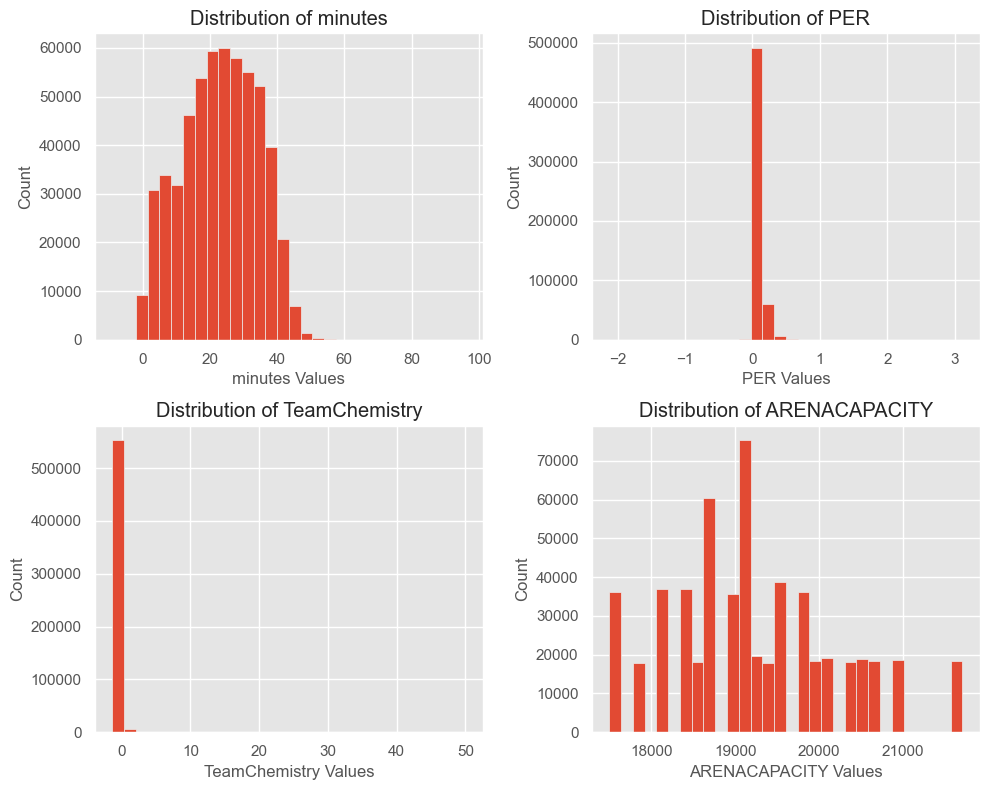

In [65]:
cols_visualize = ['minutes', 'PER', 'TeamChemistry', 'ARENACAPACITY']
visualize_distribution(most_updated, cols_visualize, rows=2, cols=2)

From the above distributions, as well as the visualizations for each variable that is shown on the Kaggle website, we can see that most of our variables are right-skewed. Will therefore log transform columns that are right-skewed to potentially help with logistic regression (assumes a linear relationship between the log-odds of the dependent variable and the independent features. Transforming skewed features can make this relationship more linear and improve the model's performance). However, random forest is robust to skewed distribution so will be interesting to see if it helps improve that.

In [66]:
## keeping only home team players as well as playing players
home_team_players = most_updated[most_updated['TEAM_ID'] == most_updated['HOME_TEAM_ID']]
only_playing_players = home_team_players[home_team_players['PER'].notna()]

In [67]:
only_playing_players.columns

Index(['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'FGM', 'FG_PCT', 'FG3_PCT', 'FT_PCT',
       'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'HOME_TEAM_ID',
       'HOME_TEAM_WINS', 'minutes', 'MIN_YEAR', 'ARENACAPACITY', 'PER',
       'TeamChemistry', 'SEASON_BIN_00-05', 'SEASON_BIN_06-10',
       'SEASON_BIN_11-15', 'SEASON_BIN_16-20', 'SEASON_BIN_21-25'],
      dtype='object')

In [68]:
## splitting into test and train dataset before any transformation/ feature engineering to prevent data leakage
from sklearn.model_selection import train_test_split
y = only_playing_players['HOME_TEAM_WINS']

X_train, X_test, y_train, y_test = train_test_split(only_playing_players, y, test_size=0.2, random_state=42)

In [69]:
def log_transform_columns(train_df, test_df, cols_to_transform):
    train_transformed = X_train.copy()
    test_transformed = X_test.copy()

    for column in cols_to_transform:
        train_transformed[column] = np.log1p(train_transformed[column])
        test_transformed[column] = np.log1p(test_transformed[column])

    return train_transformed, test_transformed

In [70]:
cols_to_transform = ['FGM', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PER',
       'TeamChemistry']
X_train_transformed, X_test_transformed = log_transform_columns(X_train, X_test, cols_to_transform)

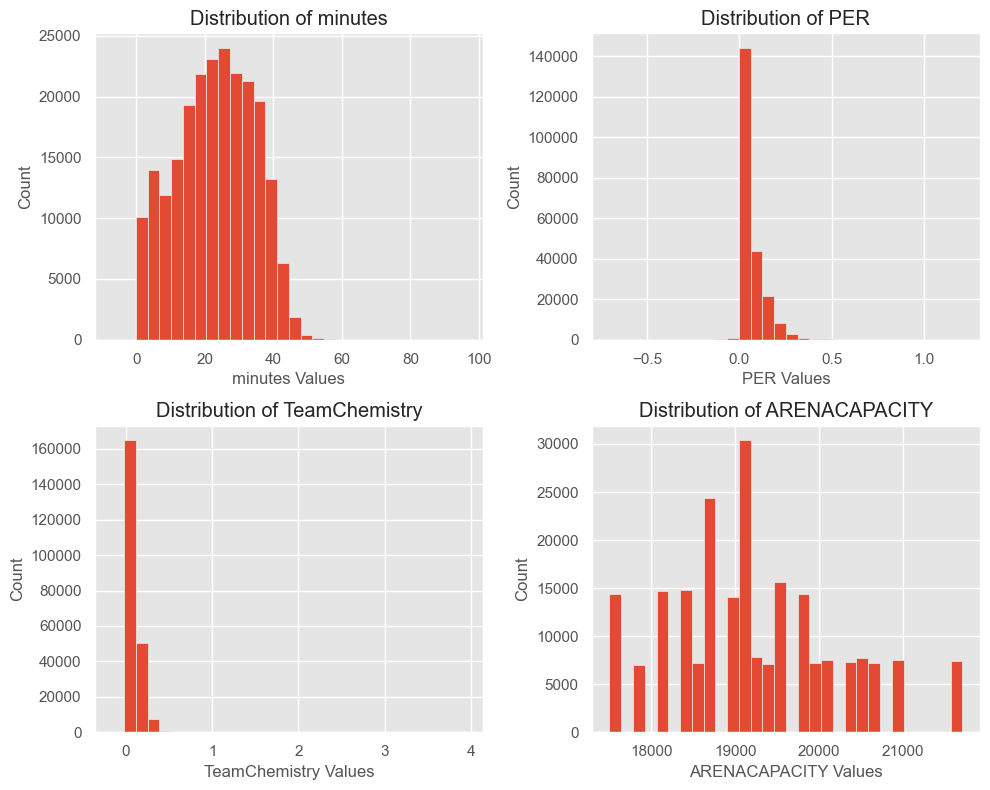

In [71]:
cols_visualize = ['minutes', 'PER', 'TeamChemistry', 'ARENACAPACITY']
visualize_distribution(X_train_transformed, cols_visualize, rows=2, cols=2)

In [72]:
X_train_avg = X_train_transformed.groupby(['GAME_ID', 'HOME_TEAM_ID'])[['MIN_YEAR', 'ARENACAPACITY', 'PER', 'TeamChemistry', 
    'PF', 'HOME_TEAM_WINS', 'SEASON_BIN_00-05', 'SEASON_BIN_06-10', 'SEASON_BIN_11-15', 'SEASON_BIN_16-20', 
    'SEASON_BIN_21-25', ]].mean().reset_index()

X_test_avg = X_test_transformed.groupby(['GAME_ID', 'HOME_TEAM_ID'])[['MIN_YEAR', 'ARENACAPACITY', 'PER', 'TeamChemistry', 
    'PF', 'HOME_TEAM_WINS', 'SEASON_BIN_00-05', 'SEASON_BIN_06-10', 'SEASON_BIN_11-15', 'SEASON_BIN_16-20', 
    'SEASON_BIN_21-25', ]].mean().reset_index()

X_train_avg

,GAME_ID,HOME_TEAM_ID,MIN_YEAR,ARENACAPACITY,PER,TeamChemistry,PF,HOME_TEAM_WINS,SEASON_BIN_00-05,SEASON_BIN_06-10,SEASON_BIN_11-15,SEASON_BIN_16-20,SEASON_BIN_21-25
0,10300001,1610612762,1974.0,20148.0,0.102437,0.200732,0.750179,1.0,1.0,0.0,0.0,0.0,0.0
1,10300002,1610612763,1995.0,18119.0,0.095467,0.226741,1.058338,1.0,1.0,0.0,0.0,0.0,0.0
2,10300003,1610612765,1948.0,21000.0,0.075937,0.170640,0.950370,0.0,1.0,0.0,0.0,0.0,0.0
3,10300004,1610612742,1980.0,19200.0,0.130664,0.202127,0.899516,1.0,1.0,0.0,0.0,0.0,0.0
4,10300005,1610612757,1970.0,19980.0,0.342688,0.251666,0.707566,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26518,52100111,1610612737,1949.0,18729.0,0.069262,0.142776,0.953416,1.0,0.0,0.0,0.0,0.0,1.0
26519,52100121,1610612750,1989.0,19356.0,0.060998,0.082891,0.954945,1.0,0.0,0.0,0.0,0.0,1.0
26520,52100131,1610612740,2002.0,17791.0,0.110430,0.094923,1.036756,1.0,0.0,0.0,0.0,0.0,1.0
26521,52100201,1610612739,1970.0,20562.0,0.045372,0.069600,1.070792,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
Y_train = X_train_avg['HOME_TEAM_WINS']
Y_test = X_test_avg['HOME_TEAM_WINS']

In [74]:
corr_w_win = X_train_avg.drop(columns = ['GAME_ID', 'HOME_TEAM_ID'])

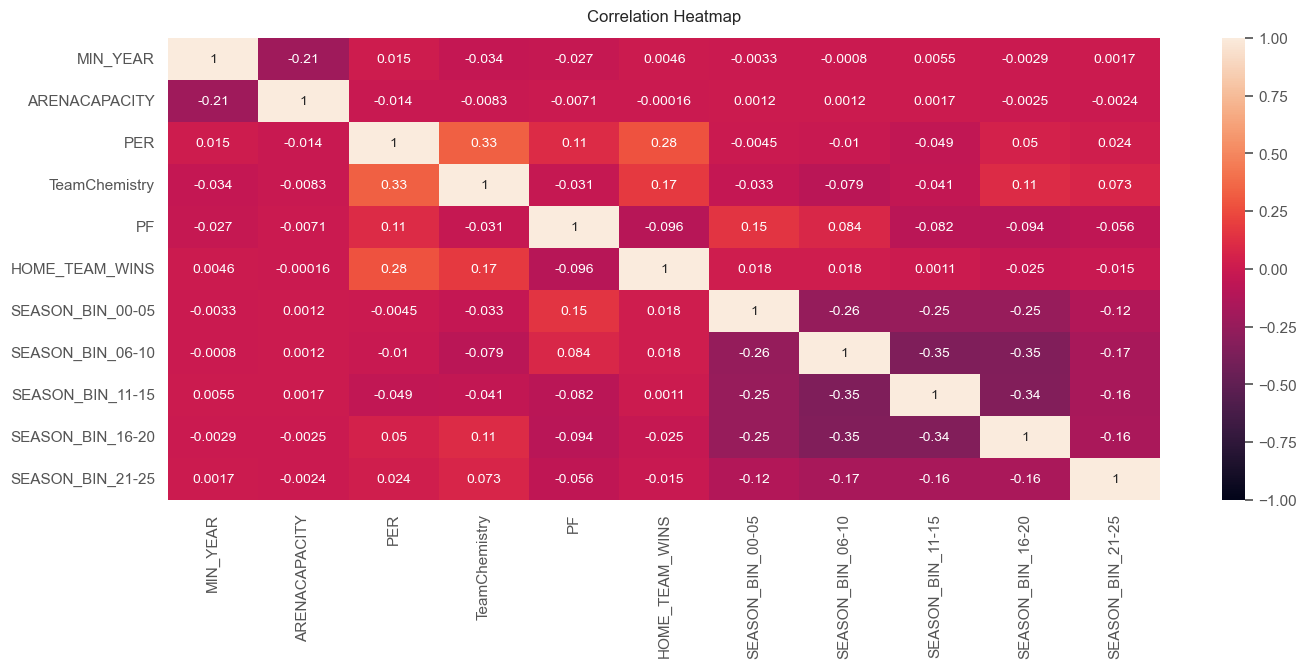

In [75]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_w_win.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Could see that there is not much correlation between the current variables and HOME_TEAM_WINS. Pure logistic regression would therefore not work well. Need to engineer better features.

MODELS

In [80]:
from sklearn.linear_model import LogisticRegression

Based on the features we've engineered above, now we want to see how many we should use for the logistic regression model based on whichever combination of features has the lowest AIC score.

In [167]:
X_train_use = X_train_avg.drop(['HOME_TEAM_WINS'], axis=1)
X_test_use = X_test_avg.drop(['HOME_TEAM_WINS'], axis=1)

In [168]:
import statsmodels.api as sm

best_aic_per_k = {}

#All subsets of size k
def get_combinations(arr, k):
    if k == 0:
        return [[]]
    if not arr: 
        return []
    return get_combinations(arr[1:], k) + [x + [arr[0]] for x in get_combinations(arr[1:], k-1)] 

# Looping through all possible sizes of predictor subsets
for k in range(1, len(X_train_use.columns) + 1):
    
    # Getting all combinations of predictors of size k without using itertools
    best_aic_k = float("inf")
    best_model_k = None
    best_variables_k = None
    
    for variables in get_combinations(list(X_train_use.columns), k):
        predictors = X_train_use[list(variables)]
        predictors = sm.add_constant(predictors)  # Add a constant (intercept) to the model
        
        # Fitting the model
        model = sm.GLM(Y_train, predictors, family=sm.families.Binomial()).fit()
        
        # Updating best AIC model for each k
        if model.aic < best_aic_k:
            best_aic_k = model.aic
            best_model_k = model
            best_variables_k = variables  # Storing variable names
    
    # Storing the best AIC and variable names for each k in the dictionary
    best_aic_per_k[k] = (best_aic_k, best_model_k, best_variables_k)

# Displaying the results
for k, (aic, model, variables) in best_aic_per_k.items():
    print(f"\nBest AIC value for k={k} variables: {aic}")
    print(f"Variables in the model: {variables}")
    print(f"Model parameters:\n{model.params}")


Best AIC value for k=1 variables: 33598.191289200244
Variables in the model: ['PER']
Model parameters:
const    -1.084102
PER      28.170348
dtype: float64

Best AIC value for k=2 variables: 33111.765964667116
Variables in the model: ['PF', 'PER']
Model parameters:
const     0.224647
PF       -1.472978
PER      30.233846
dtype: float64

Best AIC value for k=3 variables: 32859.579011472444
Variables in the model: ['PF', 'TeamChemistry', 'PER']
Model parameters:
const            -0.401453
PF               -1.414227
TeamChemistry     8.826279
PER              27.884011
dtype: float64

Best AIC value for k=4 variables: 32734.53472152645
Variables in the model: ['SEASON_BIN_16-20', 'PF', 'TeamChemistry', 'PER']
Model parameters:
const               -0.315781
SEASON_BIN_16-20    -0.350021
PF                  -1.494201
TeamChemistry        9.581046
PER                 28.284982
dtype: float64

Best AIC value for k=5 variables: 32660.586448721584
Variables in the model: ['SEASON_BIN_21-25', '

Best AIC value is for k=6 variables: 32560.619634672214. The variables used in the model: ['SEASON_BIN_11-15', 'SEASON_BIN_06-10', 'SEASON_BIN_00-05', 'PF', 'TeamChemistry', 'PER', 'HOME_TEAM_ID', 'GAME_ID']

In [ ]:
Best model we have calculated from above
Y = Y_train
X = X_train_avg[['SEASON_BIN_11-15', 'SEASON_BIN_06-10', 'SEASON_BIN_00-05', 'PF', 'TeamChemistry', 'PER', 'HOME_TEAM_ID', 'GAME_ID']]
X = sm.add_constant(X)
best_model = sm.GLM(Y, X, family=sm.families.Binomial()).fit()
print(best_model.summary())
print(f"\nBest AIC value: {best_model.aic}")

In [187]:
#Prediction for the test data
X_test_best_model = X_test_avg[['SEASON_BIN_11-15', 'SEASON_BIN_06-10', 'SEASON_BIN_00-05', 'PF', 'TeamChemistry', 'PER', 'HOME_TEAM_ID', 'GAME_ID']]
X_test_best_model = sm.add_constant(X_test_best_model)
Y_pred = best_model.predict(X_test_best_model)
Y_pred_round = list(map(round, Y_pred)) 
accuracy_bestmodel = np.mean(Y_test == Y_pred_round)
print(f"Accuracy of Logistic Regression on test set: {accuracy_bestmodel}")

Accuracy of Logistic Regression on test set: 0.5718933800525591


In [188]:
predicted_probs_log = Y_pred
predicted_probs_log.round(2)

0        0.98
1        1.00
2        1.00
3        1.00
4        0.64
         ... 
23968    0.47
23969    0.90
23970    0.34
23971    0.29
23972    0.95
Length: 23973, dtype: float64

In [189]:
def get_tpr_fpr(reality, decision_probs, threshold):
    # Compute the denominators for the top and bottom rows (reality=0, reality=1)
    r1_count = reality.sum()
    r0_count = (1-reality).sum()
    decisions = (decision_probs >= threshold).astype(int)
    table = confusion_matrix(reality, decisions)
    tp_count = table[1,1]
    fp_count = table[0,1]
    tpr = tp_count / r1_count
    fpr = fp_count / r0_count
    
    return tpr, fpr

In [190]:
from sklearn.metrics import confusion_matrix

In [198]:
results_log = []
thresholds = np.arange(0, 1.01, 0.1)
for threshold in thresholds:
    TPR, FPR = get_tpr_fpr(Y_test, predicted_probs_log, threshold)
    results_log.append((threshold, TPR, FPR))
results_log = pd.DataFrame(results, columns = ["threshold", "TPR", "FPR"])
results_log

,threshold,TPR,FPR
0,0.0,1.000000,1.000000
1,0.1,1.000000,0.986692
2,0.2,0.995683,0.936408
3,0.3,0.968858,0.814202
4,0.4,0.890934,0.614791
5,0.5,0.890934,0.614791
6,0.6,0.720575,0.365299
7,0.7,0.474556,0.146892
8,0.8,0.225777,0.033523
9,0.9,0.055630,0.000000


0.6 is the optimal threshold.

In [204]:
#Re-calculated accuracy for the best logistic model selected based on 0.6 threshold
Y_pred_log = []
for Y_pred_unit in Y_pred:
    if Y_pred_unit >= 0.6:
        Y_pred_log.append(1)
    else:
        Y_pred_log.append(0)
accuracy_bestmodel = np.mean(Y_test == Y_pred_log)
print(f"Accuracy of Logistic Regression on test set: {accuracy_bestmodel}")

Accuracy of Logistic Regression on test set: 0.5549993742960831


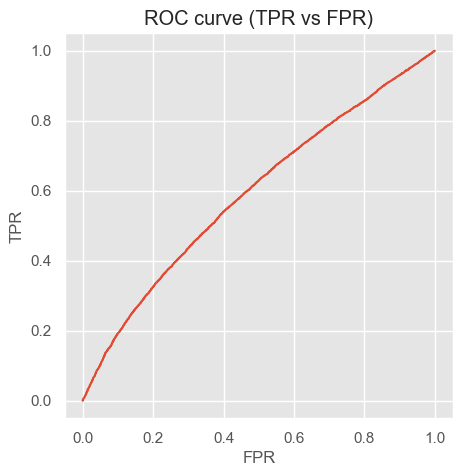

In [201]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_log, tpr_log, _ = roc_curve(Y_test, predicted_probs_log)
plt.figure(figsize=(5, 5))
plt.plot(fpr_log, tpr_log)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("ROC curve (TPR vs FPR)")
plt.show()

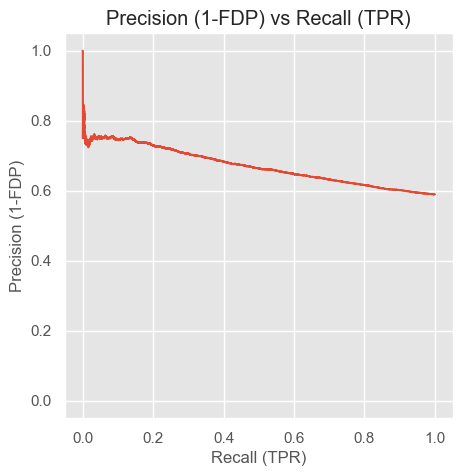

In [203]:
from sklearn.metrics import precision_recall_curve
precision_log, recall_log, _ = precision_recall_curve(Y_test, predicted_probs_log)
plt.figure(figsize = (5, 5))
plt.plot(recall_log, precision_log)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR)")
plt.show()

Let's do this the Bayesian way by using L2 regularization

In [271]:
from sklearn.linear_model import LogisticRegression

X_train_reg = X_train_avg[['SEASON_BIN_11-15', 'SEASON_BIN_06-10', 'SEASON_BIN_00-05', 'PF', 'TeamChemistry', 'PER', 'HOME_TEAM_ID', 'GAME_ID']]

regularized_lr = LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced')
regularized_lr.fit(X_train_reg, Y_train)

X_test_reg = X_test_avg[['SEASON_BIN_11-15', 'SEASON_BIN_06-10', 'SEASON_BIN_00-05', 'PF', 'TeamChemistry', 'PER', 'HOME_TEAM_ID', 'GAME_ID']]
reg_pred = regularized_lr.predict(X_test_reg)

accuracy_regmodel = np.mean(Y_test == reg_pred)
accuracy_regmodel

0.45021482501147125

The L2 regularized logistic regression gave a poor accuracy because it relies on Gaussian priors, which are not good priors. They assume that our data is Normally distributed but our data is not.

In [166]:
from sklearn.neighbors import KNeighborsClassifier

#Using k-NN classification:
k_value = 8
knn = KNeighborsClassifier(n_neighbors = k_value)
knn.fit(X_train_use, Y_train)
Y_pred_knn = knn.predict(X_test_use)
accuracy_knn = np.mean(Y_test == Y_pred_knn)
print(f"Accuracy of k-NN Classification on test set: {accuracy_knn}")
#Contingency table (or confusion matrix)
print(pd.crosstab(Y_test, Y_pred_knn, rownames=['Actual'], colnames=['Predicted'], margins=True))

Accuracy of k-NN Classification on test set: 0.6853126433904809
Predicted    0.0    1.0    All
Actual                        
0.0         6248   3596   9844
1.0         3948  10181  14129
All        10196  13777  23973


In [222]:
predicted_probs = knn.predict_proba(X_test_use)[:, 1]
predicted_probs.round(2)

array([0.88, 0.62, 0.88, ..., 0.62, 0.62, 0.62])

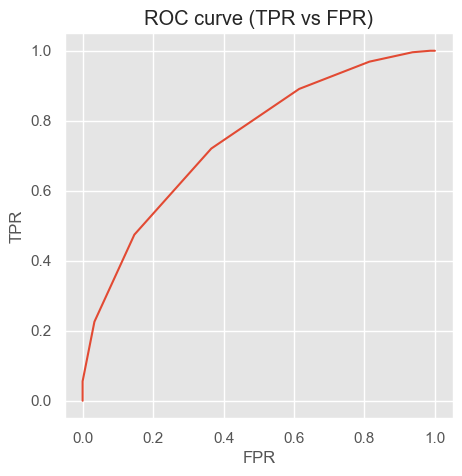

In [223]:
fpr, tpr, _ = roc_curve(Y_test, predicted_probs)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("ROC curve (TPR vs FPR)")
plt.show()

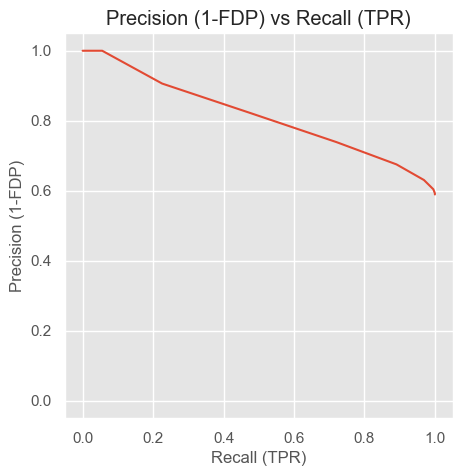

In [224]:
precision, recall, _ = precision_recall_curve(Y_test, predicted_probs)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR)")
plt.show()

In [225]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=1, max_depth=3)
dt.fit(X_train_use, Y_train)

# Predict on the test set
Y_pred_dt = dt.predict(X_test_use)

# Calculate the accuracy
accuracy_dt = np.mean(Y_test == Y_pred_dt)
print(f"Accuracy of Decision Tree Classification on test set: {accuracy_dt}")

# Create the confusion matrix (contingency table)
print(pd.crosstab(Y_test, Y_pred_dt, rownames=['Actual'], colnames=['Predicted'], margins=True))

Accuracy of Decision Tree Classification on test set: 0.5596712968756518
Predicted    0.0    1.0    All
Actual                        
0.0         5427   4417   9844
1.0         6139   7990  14129
All        11566  12407  23973


In [226]:
predicted_probs_dt = dt.predict_proba(X_test_use)[:, 1]
predicted_probs_dt.round(2)

array([0.82, 0.72, 0.82, ..., 0.43, 0.32, 0.72])

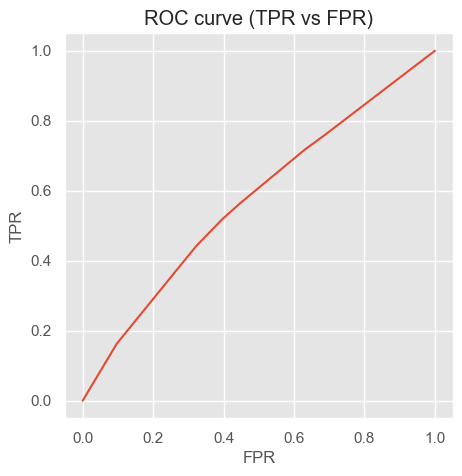

In [228]:
fpr_dt, tpr_dt, _ = roc_curve(Y_test, predicted_probs_dt)
plt.figure(figsize=(5, 5))
plt.plot(fpr_dt, tpr_dt)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("ROC curve (TPR vs FPR)")
plt.show()

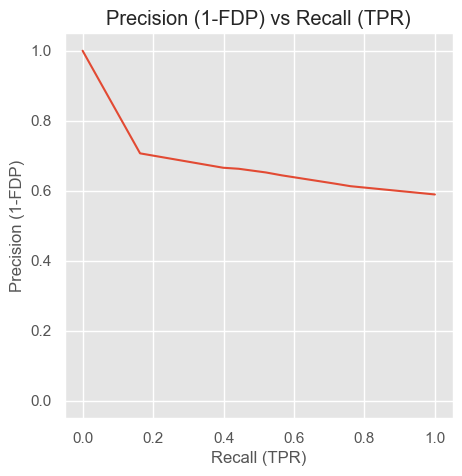

In [229]:
precision_dt, recall_dt, _ = precision_recall_curve(Y_test, predicted_probs_dt)
plt.figure(figsize = (5, 5))
plt.plot(recall_dt, precision_dt)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR)")
plt.show()

In [38]:
#Random Forest:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(random_state=1, max_features = 4)
rf.fit(X_train_use, Y_train)

# Predict on the test set
Y_pred_rf = rf.predict(X_test_use)

# Calculate the accuracy
accuracy_rf = np.mean(Y_test == Y_pred_rf)
print(f"Accuracy of Random Forest Classification on test set: {accuracy_rf}")

# Create the confusion matrix (contingency table)
print(pd.crosstab(Y_test, Y_pred_rf, rownames=['Actual'], colnames=['Predicted'], margins=True))

Accuracy of Random Forest Classification on test set: 0.5765235890376674
Predicted    0.0    1.0    All
Actual                        
0.0         5367   4477   9844
1.0         5675   8454  14129
All        11042  12931  23973


In [230]:
predicted_probs_rf = rf.predict_proba(X_test_use)[:, 1]
predicted_probs_rf.round(2)

array([0.9 , 0.56, 0.74, ..., 0.41, 0.36, 0.53])

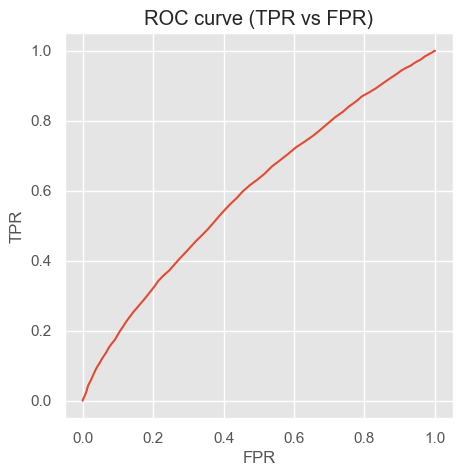

In [231]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, predicted_probs_rf)
plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("ROC curve (TPR vs FPR)")
plt.show()

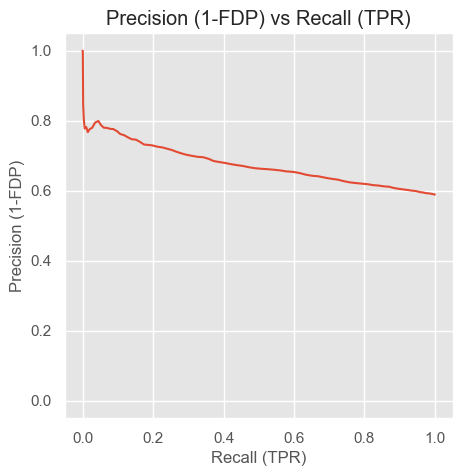

In [232]:
precision_rf, recall_rf, _ = precision_recall_curve(Y_test, predicted_probs_rf)
plt.figure(figsize = (5, 5))
plt.plot(recall_rf, precision_rf)
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (1-FDP)")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision (1-FDP) vs Recall (TPR)")
plt.show()